# 8.2 Tensorflow and Keras

In [3]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# for loading images
from tensorflow.keras.preprocessing.image import load_img

In [6]:
path = "clothing-dataset-small/train/t-shirt"
name = "00003aeb-ace5-43bf-9a0c-dc31a03e9cd2.jpg"
fullname = f'{path}/{name}'
img = load_img(fullname, target_size=(299, 299))

In [7]:
print(img)

<PIL.Image.Image image mode=RGB size=299x299 at 0x723A1D1BD0D0>


In [8]:
# we can see this image as a numpy array due to how theyre represented internally (matrices of RGB)
x = np.array(img)
x.shape

(299, 299, 3)

# 8.3 Pre-trained Convolutional Neural Networks

In [12]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [13]:
# xception mdoel from keras
model = Xception(
    weights="imagenet",
    input_shape=(299,299,3)
)

# array of images
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [14]:
X = preprocess_input(X)
X[0]

array([[[-0.18431371, -0.84313726, -0.92156863],
        [-0.17647058, -0.8352941 , -0.9137255 ],
        [-0.17647058, -0.8352941 , -0.9137255 ],
        ...,
        [-0.6627451 , -0.7254902 , -0.7411765 ],
        [-0.67058825, -0.73333335, -0.7490196 ],
        [-0.69411767, -0.75686276, -0.77254903]],

       [[-0.17647058, -0.8352941 , -0.9137255 ],
        [-0.17647058, -0.8352941 , -0.9137255 ],
        [-0.16862744, -0.827451  , -0.90588236],
        ...,
        [-0.6784314 , -0.7411765 , -0.75686276],
        [-0.6784314 , -0.7411765 , -0.75686276],
        [-0.6862745 , -0.7490196 , -0.7647059 ]],

       [[-0.16862744, -0.827451  , -0.90588236],
        [-0.16862744, -0.827451  , -0.90588236],
        [-0.1607843 , -0.81960785, -0.8980392 ],
        ...,
        [-0.67058825, -0.73333335, -0.7490196 ],
        [-0.6784314 , -0.7411765 , -0.75686276],
        [-0.7019608 , -0.7647059 , -0.78039217]],

       ...,

       [[-0.3098039 , -0.47450978, -0.6862745 ],
        [-0

In [17]:
pred = model.predict(X)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


(1, 1000)

In [18]:
decode_predictions(pred)

[[('n03595614', 'jersey', 0.88808084),
  ('n03710637', 'maillot', 0.0068297414),
  ('n04456115', 'torch', 0.0064490745),
  ('n02730930', 'apron', 0.00592232),
  ('n04235860', 'sleeping_bag', 0.005410174)]]

# 8.4 Convolutional Neural Networks

Convolutional Layers consist of filters(like small images). These images contain simple shapes(like lines).

Sliding a filter onto an image gets us a feature map that represents the filter's similarity to the parts(pixels) of the image. This means that there is one(1) feature map per filter.

Passing an image to a CNN layer will produce a vector representation of the image.

After turning the image into a vector by using the convolutional layers, we can use the dense layers to make the final prediction. Basically, the role of dense layers is to make the prediction. It is called the dense layer because of how dense the connections are in this phase of the neural network. For example, the input(features from vector) is connected to every output(in a multiclass classification). *You can have multiple dense layers*

In the case of identifying whether the object in the image is a t-shirt, the dense layer will make use of binary classification techniques.

Sidenote: Sigmoid for multiple classes is called **SOFTMAX**

# 8.5 Transfer Learning

Remember, **convolutional layers** are generic while the **dense layers** are specific to the dataset. That said, we would like to train here the dense layers to achieve what we want. That is, predicting the type of clothing the object in an image is.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_ds = train_gen.flow_from_directory('clothing-dataset-small/train', 
                              target_size=(150, 150), 
                              batch_size=32)

Found 3070 images belonging to 10 classes.


In [17]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

In [18]:
X, y = next(train_ds)

In [19]:
y[:5]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

It can be seen that it uses *one-hot encoding* for the label

In [20]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_ds = val_gen.flow_from_directory('clothing-dataset-small/validation', 
                              target_size=(150, 150), 
                              batch_size=32, 
                              shuffle=False)

Found 341 images belonging to 10 classes.


In [21]:
# set include_top false to not include the dense layers in training
base_model = Xception(weights="imagenet", 
                      include_top=False, 
                      input_shape=(150, 150, 3))
base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

In [22]:
model

<Functional name=functional, built=True>

In [23]:
print(type(model))

<class 'keras.src.models.functional.Functional'>


In [24]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

In [28]:
model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=['accuracy'])

In [29]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.9976 - loss: 0.0181 - val_accuracy: 0.8152 - val_loss: 0.9389
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9992 - loss: 0.0142 - val_accuracy: 0.8006 - val_loss: 1.0422
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9852 - loss: 0.0441 - val_accuracy: 0.8094 - val_loss: 1.0165
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9799 - loss: 0.0683 - val_accuracy: 0.8270 - val_loss: 1.0263
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9882 - loss: 0.0301 - val_accuracy: 0.8006 - val_loss: 1.1633
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9821 - loss: 0.0542 - val_accuracy: 0.7625 - val_loss: 1.3350
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9363 - loss: 0.2238 - val_accuracy: 0.7683 - val_loss: 1.9514
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9229 - loss: 0.3165 - val_accuracy: 0.8035 - v

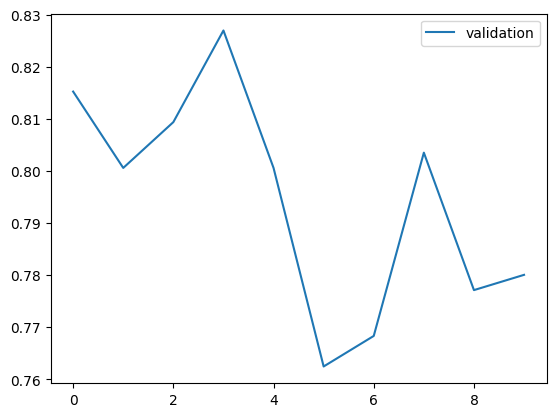

In [30]:
# plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend();

# 8.6 Learning Rate

In [46]:
def make_model(learning_rate=0.01, size_inner=100):
    # set include_top false to not include the dense layers in training
    base_model = Xception(weights="imagenet", 
                          include_top=False, 
                          input_shape=(150, 150, 3))
    base_model.trainable = False
    
    ###################################
    ### architecture here(flow of data
    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    # inner layer that takes the vectors
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)

    # take the inner layer outputs
    outputs = keras.layers.Dense(10)(inner)
    
    model = keras.Model(inputs, outputs)

    ###################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=['accuracy'])
    
    return model

In [32]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)
    
    model = make_model(lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history
    
    print("\n\n")

0.0001
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.1760 - loss: 2.4037 - val_accuracy: 0.4604 - val_loss: 1.7044
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5182 - loss: 1.5302 - val_accuracy: 0.5806 - val_loss: 1.3228
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6073 - loss: 1.2191 - val_accuracy: 0.6540 - val_loss: 1.1240
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6740 - loss: 1.0487 - val_accuracy: 0.6921 - val_loss: 1.0088
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6909 - loss: 0.9575 - val_accuracy: 0.7185 - val_loss: 0.9222
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7195 - loss: 0.8758 - val_accuracy: 0.7361 - val_loss: 0.8693
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7415 - loss: 0.8075 - val_accuracy: 0.7419 - val_loss: 0.8229
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7532 - loss: 0.7661 - val_accuracy: 0.7

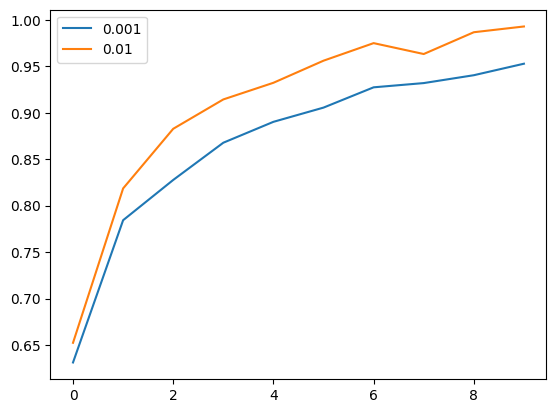

In [36]:
for lr, hst in scores.items():
    plt.plot(hst['accuracy'], label=lr)
plt.legend();

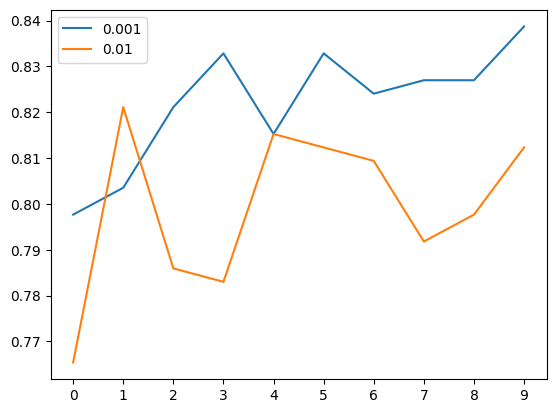

In [37]:
for lr, hst in scores.items():
    plt.plot(hst['val_accuracy'], label=lr)
plt.xticks(np.arange(10))
plt.legend();

In [42]:
learning_rate = 0.001

# 8.7 Checkpointing

In [41]:
model.save('model_v1.keras')

In [43]:
# save only when there's improvement with save_best_only=True
checkpoint = keras.callbacks.ModelCheckpoint('xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
                               save_best_only=True,
                               monitor='val_accuracy',
                               mode='max')

In [44]:
model = make_model(learning_rate=learning_rate)
history = model.fit(train_ds, 
                    epochs=10, 
                    validation_data=val_ds,
                    callbacks=[checkpoint])

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.4932 - loss: 1.4922 - val_accuracy: 0.7683 - val_loss: 0.7423
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7994 - loss: 0.6238 - val_accuracy: 0.8035 - val_loss: 0.6487
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8249 - loss: 0.5332 - val_accuracy: 0.8035 - val_loss: 0.6105
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8563 - loss: 0.4470 - val_accuracy: 0.8094 - val_loss: 0.5573
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8882 - loss: 0.3680 - val_accuracy: 0.8182 - val_loss: 0.5622
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9115 - loss: 0.3097 - val_accuracy: 0.8211 - val_loss: 0.5655
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9203 - loss: 0.2923 - val_accuracy: 0.8328 - val_loss: 0.5413
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9296 - loss: 0.2555 - val_accuracy: 0.8211 - v

# 8.8 Adding more layers

In [45]:
learning_rate

0.001

In [48]:
scores = {}

for size in [10, 100, 1000]:
    print(size)
    
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history
    
    print("\n\n")

10
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.4233 - loss: 1.7286 - val_accuracy: 0.6276 - val_loss: 1.2118
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6628 - loss: 1.0936 - val_accuracy: 0.7302 - val_loss: 0.9259
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7365 - loss: 0.8359 - val_accuracy: 0.7537 - val_loss: 0.7814
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7856 - loss: 0.6396 - val_accuracy: 0.7683 - val_loss: 0.7149
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8339 - loss: 0.5371 - val_accuracy: 0.7654 - val_loss: 0.6975
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8508 - loss: 0.4829 - val_accuracy: 0.7566 - val_loss: 0.6751
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8631 - loss: 0.4488 - val_accuracy: 0.7654 - val_loss: 0.7051
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8976 - loss: 0.3613 - val_accuracy: 0.7713 

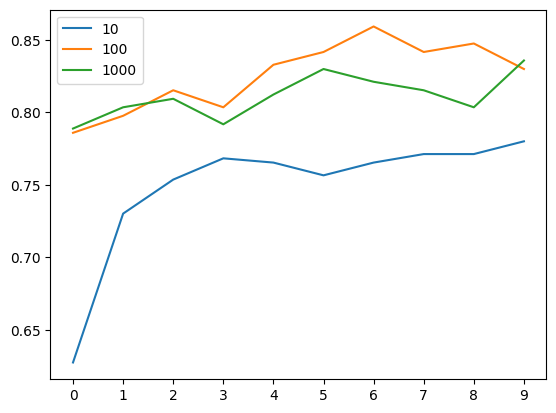

In [50]:
for size, hst in scores.items():
    plt.plot(hst['val_accuracy'], label=size)
plt.xticks(np.arange(10))
plt.legend();

# 8.9 Regularization and Dropout